# KANs with Wavelets

Replace B-Splines with Wavelets
Following base code is taken from [WavKAN](https://github.com/zavareh1/Wav-KAN)
and this notebooks on [Wavelet Regression](https://github.com/jseabold/web-site/blob/master/content/notebooks/wavelet-regression-in-python.ipynb)

In [1]:
'''This is a sample code for the simulations of the paper:
Bozorgasl, Zavareh and Chen, Hao, Wav-KAN: Wavelet Kolmogorov-Arnold Networks (May, 2024)

https://arxiv.org/abs/2405.12832
and also available at:
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4835325
We used efficient KAN notation and some part of the code:https://github.com/Blealtan/efficient-kan

'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import math

class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, wavelet_type='mexican_hat'):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.wavelet_type = wavelet_type

        # Parameters for wavelet transformation
        self.scale = nn.Parameter(torch.ones(out_features, in_features))
        self.translation = nn.Parameter(torch.zeros(out_features, in_features))

        # Linear weights for combining outputs
        #self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight1 = nn.Parameter(torch.Tensor(out_features, in_features)) #not used; you may like to use it for wieghting base activation and adding it like Spl-KAN paper
        self.wavelet_weights = nn.Parameter(torch.Tensor(out_features, in_features))

        nn.init.kaiming_uniform_(self.wavelet_weights, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.weight1, a=math.sqrt(5))

        # Base activation function #not used for this experiment
        self.base_activation = nn.SiLU()

        # Batch normalization
        self.bn = nn.BatchNorm1d(out_features)

    def wavelet_transform(self, x):
        if x.dim() == 2:
            x_expanded = x.unsqueeze(1)
        else:
            x_expanded = x

        translation_expanded = self.translation.unsqueeze(0).expand(x.size(0), -1, -1)
        scale_expanded = self.scale.unsqueeze(0).expand(x.size(0), -1, -1)
        x_scaled = (x_expanded - translation_expanded) / scale_expanded

        # Implementation of different wavelet types
        if self.wavelet_type == 'mexican_hat':
            term1 = ((x_scaled ** 2)-1)
            term2 = torch.exp(-0.5 * x_scaled ** 2)
            wavelet = (2 / (math.sqrt(3) * math.pi**0.25)) * term1 * term2
            wavelet_weighted = wavelet * self.wavelet_weights.unsqueeze(0).expand_as(wavelet)
            wavelet_output = wavelet_weighted.sum(dim=2)
        elif self.wavelet_type == 'morlet':
            omega0 = 5.0  # Central frequency
            real = torch.cos(omega0 * x_scaled)
            envelope = torch.exp(-0.5 * x_scaled ** 2)
            wavelet = envelope * real
            wavelet_weighted = wavelet * self.wavelet_weights.unsqueeze(0).expand_as(wavelet)
            wavelet_output = wavelet_weighted.sum(dim=2)
            
        elif self.wavelet_type == 'dog':
            # Implementing Derivative of Gaussian Wavelet 
            dog = -x_scaled * torch.exp(-0.5 * x_scaled ** 2)
            wavelet = dog
            wavelet_weighted = wavelet * self.wavelet_weights.unsqueeze(0).expand_as(wavelet)
            wavelet_output = wavelet_weighted.sum(dim=2)
        elif self.wavelet_type == 'meyer':
            # Implement Meyer Wavelet here
            # Constants for the Meyer wavelet transition boundaries
            v = torch.abs(x_scaled)
            pi = math.pi

            def meyer_aux(v):
                return torch.where(v <= 1/2,torch.ones_like(v),torch.where(v >= 1,torch.zeros_like(v),torch.cos(pi / 2 * nu(2 * v - 1))))

            def nu(t):
                return t**4 * (35 - 84*t + 70*t**2 - 20*t**3)
            # Meyer wavelet calculation using the auxiliary function
            wavelet = torch.sin(pi * v) * meyer_aux(v)
            wavelet_weighted = wavelet * self.wavelet_weights.unsqueeze(0).expand_as(wavelet)
            wavelet_output = wavelet_weighted.sum(dim=2)
        elif self.wavelet_type == 'shannon':
            # Windowing the sinc function to limit its support
            pi = math.pi
            sinc = torch.sinc(x_scaled / pi)  # sinc(x) = sin(pi*x) / (pi*x)

            # Applying a Hamming window to limit the infinite support of the sinc function
            window = torch.hamming_window(x_scaled.size(-1), periodic=False, dtype=x_scaled.dtype, device=x_scaled.device)
            # Shannon wavelet is the product of the sinc function and the window
            wavelet = sinc * window
            wavelet_weighted = wavelet * self.wavelet_weights.unsqueeze(0).expand_as(wavelet)
            wavelet_output = wavelet_weighted.sum(dim=2)
            #You can try many more wavelet types ...
        else:
            raise ValueError("Unsupported wavelet type")

        return wavelet_output

    def forward(self, x):
        wavelet_output = self.wavelet_transform(x)
        #You may like test the cases like Spl-KAN
        #wav_output = F.linear(wavelet_output, self.weight)
        #base_output = F.linear(self.base_activation(x), self.weight1)

        base_output = F.linear(x, self.weight1)
        combined_output =  wavelet_output #+ base_output 

        # Apply batch normalization
        return self.bn(combined_output)

class KAN(nn.Module):
    def __init__(self, layers_hidden, wavelet_type='mexican_hat'):
        super(KAN, self).__init__()
        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden[:-1], layers_hidden[1:]):
            self.layers.append(KANLinear(in_features, out_features, wavelet_type))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

**Function Fitting**

We will take some interesting test functions from [Wavelet Regression](https://github.com/jseabold/web-site/blob/master/content/notebooks/wavelet-regression-in-python.ipynb) notebook.

The Doppler function is 
$$
f(x) = x(1-x) \sin(\frac{2.1\pi}{x+0.05}) \\
x \sim U[0,1]
$$


device is:  cpu
train input data shape torch.Size([1000, 1])
train label data shape torch.Size([1000, 1])


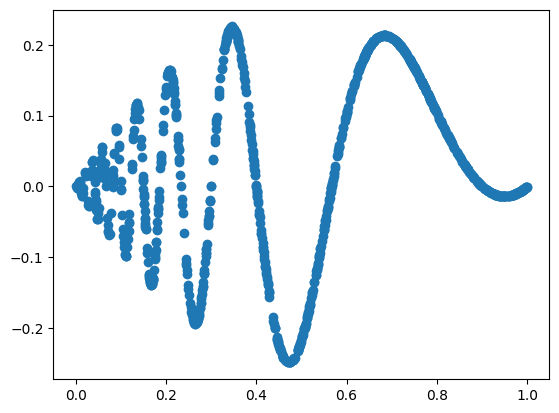

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from kan.utils import create_dataset

torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device is: ',device)

f = lambda x: x[:,[0]]*(1-x[:,[0]])*torch.sin((2*np.pi)/(x[:,[0]]+.1))

dataset = create_dataset(f, n_var=1, device=device, ranges=[0,1])

print('train input data shape', dataset['train_input'].shape)
print('train label data shape', dataset['train_label'].shape)

plt.scatter(dataset['train_input'],dataset['train_label'])

In [3]:
# Define model
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a KAN: 1D inputs, 1D output, and 5 hidden neurons.
model = KAN([1, 32, 1], wavelet_type='mexican_hat')
model.to(device)

# Define loss
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [4]:
def train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses):
    for epoch in range(num_epochs):
        #clear out the gradients from the last step loss.backward()
        model.train()
        optimizer.zero_grad()
        
        #forward feed
        output_train = model(X_train)

        #calculate the loss
        loss_train = criterion(output_train, y_train)


        #backward propagation: calculate gradients
        loss_train.backward()

        #update the weights
        optimizer.step()
        
        model.eval()
        output_test = model(X_test)
        loss_test = criterion(output_test,y_test)

        train_losses[epoch] = loss_train.item()
        test_losses[epoch] = loss_test.item()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}")
    return model, train_losses, test_losses



import numpy as np
num_epochs = 1000
train_losses = np.zeros(num_epochs)
test_losses  = np.zeros(num_epochs)
X_train = dataset['train_input']
y_train = dataset['train_label']
X_test = dataset['test_input']
y_test = dataset['test_label']
mlp, train_losses, test_losses = train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses)

Epoch 50/1000, Train Loss: 0.2128, Test Loss: 0.2410
Epoch 100/1000, Train Loss: 0.0273, Test Loss: 0.0248
Epoch 150/1000, Train Loss: 0.0039, Test Loss: 0.0032
Epoch 200/1000, Train Loss: 0.0020, Test Loss: 0.0018
Epoch 250/1000, Train Loss: 0.0014, Test Loss: 0.0018
Epoch 300/1000, Train Loss: 0.0012, Test Loss: 0.0014
Epoch 350/1000, Train Loss: 0.0011, Test Loss: 0.0014
Epoch 400/1000, Train Loss: 0.0010, Test Loss: 0.0013
Epoch 450/1000, Train Loss: 0.0009, Test Loss: 0.0014
Epoch 500/1000, Train Loss: 0.0009, Test Loss: 0.0020
Epoch 550/1000, Train Loss: 0.0009, Test Loss: 0.0035
Epoch 600/1000, Train Loss: 0.0008, Test Loss: 0.0038
Epoch 650/1000, Train Loss: 0.0008, Test Loss: 0.0026
Epoch 700/1000, Train Loss: 0.0008, Test Loss: 0.0027
Epoch 750/1000, Train Loss: 0.0009, Test Loss: 0.0010
Epoch 800/1000, Train Loss: 0.0008, Test Loss: 0.0010
Epoch 850/1000, Train Loss: 0.0008, Test Loss: 0.0035
Epoch 900/1000, Train Loss: 0.0008, Test Loss: 0.0039
Epoch 950/1000, Train Loss: 0

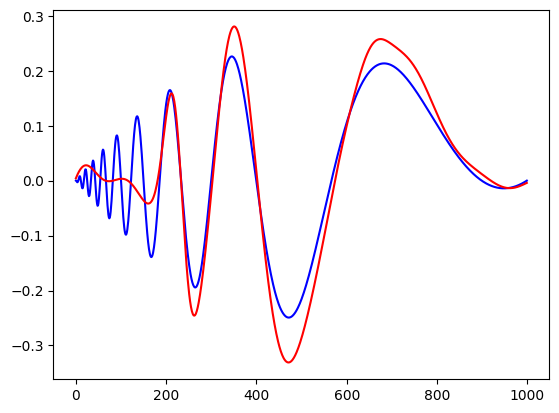

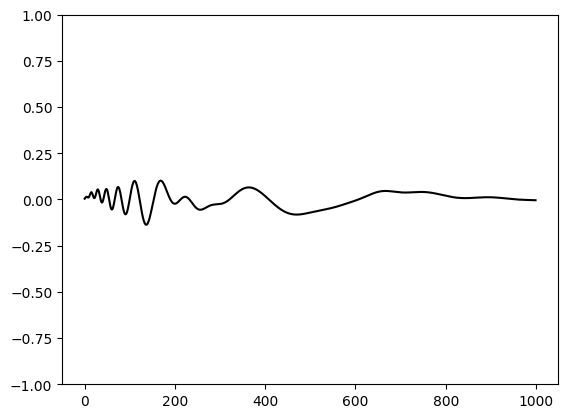

In [5]:
# let us look at the recontruction
X = dataset['train_input']
n  = 1000
X[:,0] = torch.linspace(0,1,steps=n)
y = f(X)
y = y[:,0].detach().numpy()
yh = model.forward(X)

yh = yh[:,0].detach().numpy()
plt.plot(y,color='blue')
plt.plot(yh, color='red')
plt.show()
plt.plot(yh-y, color='black')
plt.ylim(-1,1)
plt.show()